# [Friendly Introduction to Temporal Graph Neural Networks (and some Traffic Forecasting)](https://youtu.be/WEWq93tioC4?list=PLV8yxwGOxvvoNkzPfCx2i8an--Tkt7O8Z)
 - **Nodes**: Traffic sensors, **Node features**: speed & traffic volume (number of vehicles), **Directed Edge**: direction of traffic and the connectivity (street) between the sensors, **Edge property**: distance between the sensors (via street connection)
 - Formed a static graph with temporal signals. This graph receive infomation in 2 dimension - 
   1. spatial features (GNN), and 
   2. at different time points, i.e. a time series forcasting problem (Prior alternatives: ARIMA (statistical), LSTM & GRU (DL)). 
 - Combining this to leads to a **Temporal GNN**, a two step process. However, a bit more complex method is also available, where the message is passed in spatiotemporal scale. In stead of performing the GNN and LSTM/GRU one after the other, these are combined together.
 - There are many varieties: PyTorch Geometric Temporal: Spatiotemporal Signal Processing with Neural Machine Learning Models, Rozemberczki et al.
 - Dynamic GNN: [TEMPORAL GRAPH NETWORKS FOR DEEP LEARNING
ON DYNAMIC GRAPHS](https://arxiv.org/pdf/1707.01926.pdf) 

Package Description: **Pytorch Geometric Temporal** has mainly four components
 - Data Structures: three types - 
    - StaticGraphTemporalSignal
    - DynamicGraphTemporalSignal 
    - DynamicGraphStaticSignal
 - Spatiotemporal Signal Splitting: train-test splitting with temporal aspect taken in account.
 - Temporal GNN Layers: ~28 different types are avaiable (as of 2022) 
 - Datasets: includes the traffic forcasting dataset (used here)

## Imports

In [5]:
import torch
from IPython.display import clear_output
print(torch.__version__)

%pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
%pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
%pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
%pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
%pip install torch-geometric
%pip install torch-geometric-temporal
clear_output()

In [6]:
import numpy as np
from torch_geometric_temporal.dataset import METRLADatasetLoader
from torch_geometric_temporal.signal import StaticGraphTemporalSignal

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

`import ssl...` [Needed when](https://github.com/benedekrozemberczki/pytorch_geometric_temporal/issues/236#issuecomment-1620911112)
 `SSLCertVerificationError` occur while doing `loader = METRLADatasetLoader()`
> ... 
> SSLCertVerificationError: [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:992)
> 
> During handling of the above exception, another exception occurred:
> 
> URLError  
> ...

## Dataset
- Traffic forecasting dataset based on Los Angeles Metropolitan traffic
- 207 loop detectors on highways
- March 2012 - June 2012, 5 minutes interval.
- From the paper: Diffusion Convolutional Recurrent Neural Network (DCRNN) `"Diffusion Convolutional Recurrent Neural Network: Data-Driven Traffic Forecasting" <https://arxiv.org/abs/1707.01926>`
- Data Sample: 
    - [**METRLADatasetLoader** (documentation)](https://pytorch-geometric-temporal.readthedocs.io/en/latest/_modules/torch_geometric_temporal/dataset/metr_la.html#METRLADatasetLoader)
    - x: 207 nodes (sensors), 2 features per node (speed and time), 12 timestep per bucket (12x5min=60min)
    - Labels (y) for 12 future timesteps (normalized speed) --> node regression
    - Speed labels are normalized (i.e. not the absolute value), so we cannot directly interpret them.

In [7]:
loader = METRLADatasetLoader()
dataset = loader.get_dataset(num_timesteps_in=12, num_timesteps_out=12)

> TypeError: unhashable type: 'Data'

- [You cannot put mutable things in a set.](https://stackoverflow.com/a/13464168/9592557) Lists have an immutable equivalent, called a 'tuple'. This is how you would write a piece of code that took a list of lists, removed duplicate lists, then count with `len()`
- Or, use [chain](https://stackoverflow.com/a/13474914/9592557)


In [8]:
print("Number of samples/sequences: ",  len(set(map(tuple, dataset))))

# Show first sample
print(next(iter(dataset)))

Number of samples/sequences:  34249
Data(x=[207, 2, 12], edge_index=[2, 1722], edge_attr=[1722], y=[207, 12])


`num_timesteps_in=12, num_timesteps_out=12` means we are using a sequence 12 timesteps for predicting 12 timestep in the future.

**Note**: Data arrangment can be different depending on datasets/dataloaders. Sometime `offset` or `lags` have to be provided by the user depending on how far someone take account in the past or want to predict.

In [9]:
from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
d = ChickenpoxDatasetLoader().get_dataset(lags=4)
next(iter(d))

Data(x=[20, 4], edge_index=[2, 102], edge_attr=[102], y=[20])


Look at the source-code to see how a dataset is constructed:
    -`Chickenpox` would be a classical **predict-next-timestep dataset** (the label is one step later than the features).
    - `METRLA` would be a **sequence-to-sequence prediction dataset** that predicts further into the future than just the next timestep. You can also see, that the features are used as label as well.

<Axes: >

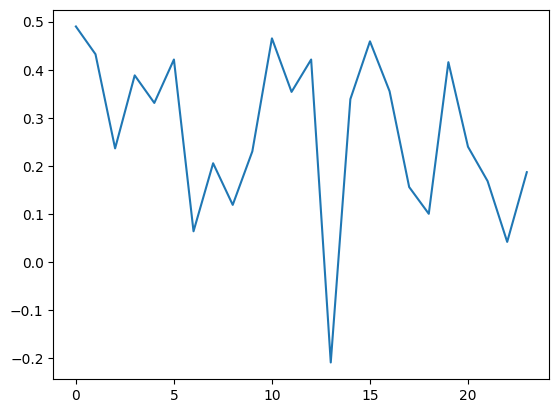

In [10]:
import seaborn as sns
sensorNumber=206
hours=24
sensorLabels=[bucket.y[sensorNumber][0].item() for bucket in list(dataset)[:hours]]
sns.lineplot(data=sensorLabels)

### Train Test Split

In [11]:
from torch_geometric_temporal.signal import temporal_signal_split
trainDataset, testDataset = temporal_signal_split(dataset, train_ratio=0.8)

# print("Number of train buckets: ", len(set(trainDataset)))
len(set(map(tuple, trainDataset)))
# print("Number of test buckets: ", len(set(testDataset)))

27399

## Model
	
- Which model to choose depends on the type of time-series task
- `A3TGCN` is an extension of `TGCN` that uses attention
	- The spatial aggregation uses GCN, the temporal aggregation a GRU
- We can pass in periods to get an embedding for several timesteps
- This embedding can be used to predict several steps into the future `out_features`
- We could also do this in a loop and feed it again into the model (would be autoregressive)
- There is only one block here. Other layers also allow stacking???

In [21]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import A3TGCN
from tqdm import tqdm

class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN(in_channels=node_features, 
                           out_channels=32, 
                           periods=periods)
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index)
        h = F.relu(h)
        h = self.linear(h)
        return h

TemporalGNN(node_features=2, periods=12)

TemporalGNN(
  (tgnn): A3TGCN(
    (_base_tgcn): TGCN(
      (conv_z): GCNConv(2, 32)
      (linear_z): Linear(in_features=64, out_features=32, bias=True)
      (conv_r): GCNConv(2, 32)
      (linear_r): Linear(in_features=64, out_features=32, bias=True)
      (conv_h): GCNConv(2, 32)
      (linear_h): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (linear): Linear(in_features=32, out_features=12, bias=True)
)

## Training

In [ ]:
import os 
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.9"
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

device = torch.device('mps') # cuda
print(device)
subset = 2000 #2000

# Create model and optimizers
model = TemporalGNN(node_features=2, periods=12).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()

print("Running training...")
for epoch in tqdm(range(10)): 
    loss = 0
    step = 0
    for snapshot in trainDataset:
        snapshot = snapshot.to(device)
        # Get model predictions
        y_hat = model(snapshot.x, snapshot.edge_index)
        # Mean squared error
        loss = loss + torch.mean((y_hat-snapshot.y)**2) 
        step += 1
        if step > subset:
          break

    loss = loss / (step + 1)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print("Epoch {} train MSE: {:.4f}".format(epoch, loss.item()))

M1Pro with 32 GB memory is **not sufficient to run a subset of more than 1100 datapoints** of this model, leading to memory error.
> RuntimeError: MPS backend out of memory (MPS allocated: 36.17 GB, other allocations: 104.36 MB, max allowed: 36.27 GB). Tried to allocate 256 bytes on shared pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

[MPS backend out of memory](https://github.com/AUTOMATIC1111/stable-diffusion-webui/issues/9133#issuecomment-1620334034)

In [22]:
# GPU support
device = torch.device('mps') # cuda
print(device)
subset = 500 #2000

# Create model and optimizers
model = TemporalGNN(node_features=2, periods=12).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()

print("Running training...")
for epoch in tqdm(range(10)): 
    loss = 0
    step = 0
    for snapshot in trainDataset:
        snapshot = snapshot.to(device)
        # Get model predictions
        y_hat = model(snapshot.x, snapshot.edge_index)
        # Mean squared error
        loss = loss + torch.mean((y_hat-snapshot.y)**2) 
        step += 1
        if step > subset:
          break

    loss = loss / (step + 1)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print("Epoch {} train MSE: {:.4f}".format(epoch, loss.item()))

mps
Running training...


 10%|█         | 1/10 [01:17<11:41, 77.95s/it]

Epoch 0 train MSE: 0.8033


 20%|██        | 2/10 [02:40<10:46, 80.84s/it]

Epoch 1 train MSE: 0.7887


 30%|███       | 3/10 [04:02<09:28, 81.23s/it]

Epoch 2 train MSE: 0.7725


 40%|████      | 4/10 [05:24<08:09, 81.51s/it]

Epoch 3 train MSE: 0.7521


 50%|█████     | 5/10 [06:45<06:46, 81.29s/it]

Epoch 4 train MSE: 0.7266


 60%|██████    | 6/10 [08:07<05:25, 81.50s/it]

Epoch 5 train MSE: 0.6962


 70%|███████   | 7/10 [09:27<04:03, 81.23s/it]

Epoch 6 train MSE: 0.6619


 80%|████████  | 8/10 [10:47<02:41, 80.66s/it]

Epoch 7 train MSE: 0.6260


 90%|█████████ | 9/10 [12:12<01:22, 82.12s/it]

Epoch 8 train MSE: 0.5910


100%|██████████| 10/10 [13:33<00:00, 81.31s/it]

Epoch 9 train MSE: 0.5605


In [23]:
# GPU support
device = torch.device('mps') # cuda
print(device)
subset = 1000 #2000

# Create model and optimizers
model = TemporalGNN(node_features=2, periods=12).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()

print("Running training...")
for epoch in tqdm(range(10)): 
    loss = 0
    step = 0
    for snapshot in trainDataset:
        snapshot = snapshot.to(device)
        # Get model predictions
        y_hat = model(snapshot.x, snapshot.edge_index)
        # Mean squared error
        loss = loss + torch.mean((y_hat-snapshot.y)**2) 
        step += 1
        if step > subset:
          break

    loss = loss / (step + 1)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print("Epoch {} train MSE: {:.4f}".format(epoch, loss.item()))

mps
Running training...


 10%|█         | 1/10 [02:53<25:58, 173.19s/it]

Epoch 0 train MSE: 0.6441


 20%|██        | 2/10 [05:57<23:56, 179.51s/it]

Epoch 1 train MSE: 0.6285


 30%|███       | 3/10 [09:39<23:12, 199.00s/it]

Epoch 2 train MSE: 0.6120


 40%|████      | 4/10 [13:37<21:26, 214.41s/it]

Epoch 3 train MSE: 0.5925


 50%|█████     | 5/10 [17:34<18:32, 222.59s/it]

Epoch 4 train MSE: 0.5695


 60%|██████    | 6/10 [20:40<14:00, 210.19s/it]

Epoch 5 train MSE: 0.5436


 70%|███████   | 7/10 [23:36<09:56, 198.87s/it]

Epoch 6 train MSE: 0.5159


 80%|████████  | 8/10 [26:30<06:22, 191.18s/it]

Epoch 7 train MSE: 0.4879


 90%|█████████ | 9/10 [29:27<03:06, 186.71s/it]

Epoch 8 train MSE: 0.4615


100%|██████████| 10/10 [32:25<00:00, 194.53s/it]

Epoch 9 train MSE: 0.4382


In [28]:
# GPU support
device = torch.device('mps') # cuda
print(device)
subset = 1100 #2000

# Create model and optimizers
model = TemporalGNN(node_features=2, periods=12).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()

print("Running training...")
for epoch in tqdm(range(10)): 
    loss = 0
    step = 0
    for snapshot in trainDataset:
        snapshot = snapshot.to(device)
        # Get model predictions
        y_hat = model(snapshot.x, snapshot.edge_index)
        # Mean squared error
        loss = loss + torch.mean((y_hat-snapshot.y)**2) 
        step += 1
        if step > subset:
          break

    loss = loss / (step + 1)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print("Epoch {} train MSE: {:.4f}".format(epoch, loss.item()))

mps
Running training...


 10%|█         | 1/10 [03:17<29:34, 197.12s/it]

Epoch 0 train MSE: 0.6271


 20%|██        | 2/10 [07:18<29:43, 222.94s/it]

Epoch 1 train MSE: 0.6087


 30%|███       | 3/10 [11:14<26:44, 229.27s/it]

Epoch 2 train MSE: 0.5900


 40%|████      | 4/10 [15:01<22:48, 228.04s/it]

Epoch 3 train MSE: 0.5688


 50%|█████     | 5/10 [18:59<19:19, 231.85s/it]

Epoch 4 train MSE: 0.5443


 60%|██████    | 6/10 [23:16<16:01, 240.34s/it]

Epoch 5 train MSE: 0.5173


 70%|███████   | 7/10 [27:13<11:57, 239.28s/it]

Epoch 6 train MSE: 0.4894


 80%|████████  | 8/10 [31:08<07:55, 237.75s/it]

Epoch 7 train MSE: 0.4629


 90%|█████████ | 9/10 [35:06<03:58, 238.10s/it]

Epoch 8 train MSE: 0.4408


100%|██████████| 10/10 [39:09<00:00, 234.93s/it]

Epoch 9 train MSE: 0.4253


## Evaluation

  - Lets get some sample predictions for a specific horizon (e.g. 24 hours * 12 = 288), 5 min interval recording.
  - The model always gets one hour and needs to predict the next hour

In [29]:
model.eval()
loss = 0
step = 0
horizon = 288

# Store for analysis
predictions = []
labels = []

for snapshot in testDataset:
    snapshot = snapshot.to(device)
    # Get predictions
    pred_y = model(snapshot.x, snapshot.edge_index)
    # Mean squared error
    loss = loss + torch.mean((pred_y - snapshot.y)**2)
    # Store for analysis below
    labels.append(snapshot.y)
    predictions.append(pred_y)
    step += 1
    if step > horizon:
          break

loss = loss / (step+1)
loss = loss.item()
print("Test MSE: {:.4f}".format(loss))

Test MSE: 0.7139


## Visualization

 - The further away the point in time is, the worse the predictions get
 - Predictions shape: [num_data_points, num_sensors, num_timesteps]

In [30]:
import numpy as np

sensor = 123
timestep = 11 
preds = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in predictions])
labs  = np.asarray([label[sensor][timestep].cpu().numpy() for label in labels])
print("Data points:,", preds.shape)

Data points:, (289,)


<Axes: >

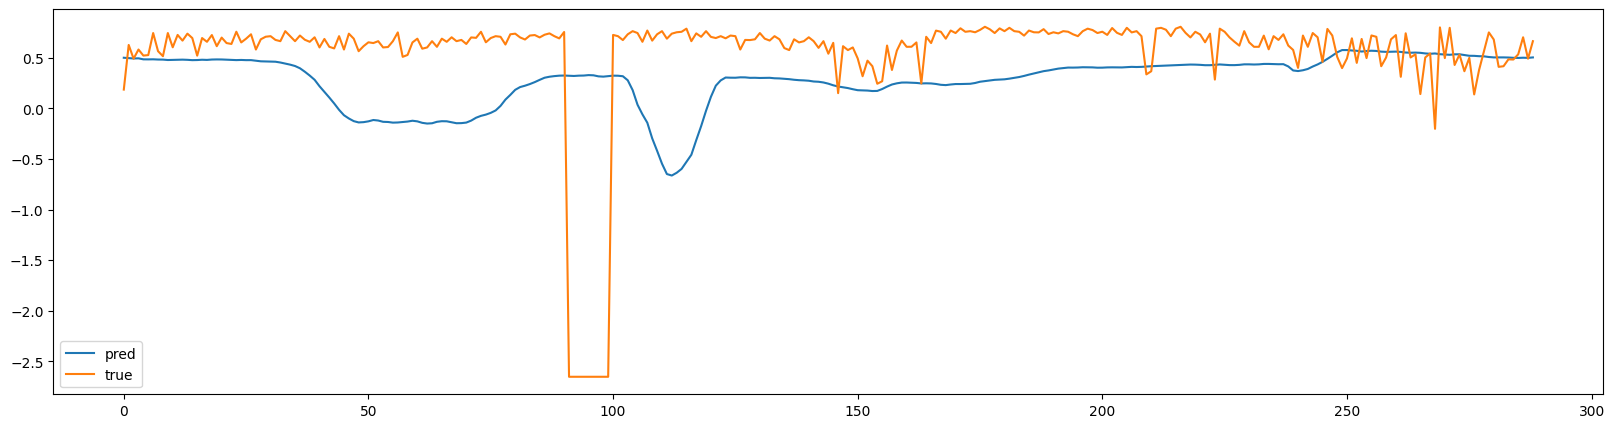

In [32]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(20,5))
sns.lineplot(data=preds, label="pred")
sns.lineplot(data=labs, label="true")